In [1]:
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 4
DATA_LENGTH = 1000
EPOCH = 100

REF_H, REF_W = 768, 1024

AIM_RES = 512

IMAGE_PATH = 'E:\\dataset\\completed\\mixed\\'
MASK_PATH = 'E:\\dataset\\completed\\mask\\'
PEOPLE_PATH = 'E:\\dataset\\completed\\people\\'
BACKGROUND_PATH = 'E:\\dataset\\completed\\background\\'
MASKED_BACKGROUND_PATH = 'E:\\dataset\\completed\\masked_background\\'

INFER_PATH = '.\\inference_images\\'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class CustomDataset(Dataset):
    def __init__(self, masked_background_path, background_path, transform = None):
        self.masked_background_path = masked_background_path
        self.background_path = background_path
        self.transform = transform
    
    def __getitem__(self, idx):
        masked_background = Image.open(self.masked_background_path[idx]).convert('RGB')
        background = Image.open(self.background_path[idx]).convert('RGB')
        
        random_seed = np.random.randint(-99999, 99999)
        if self.transform:
            torch.manual_seed(random_seed)
            masked_background = self.transform(masked_background)
            torch.manual_seed(random_seed)
            background = self.transform(background)
            
        masked_background = (masked_background + 1) / 2
        background = (background + 1) / 2
            
        noise_image = np.random.rand(3, AIM_RES, AIM_RES)
        noise_idx = np.where(masked_background.numpy() != 0)
        noise_image[noise_idx] = np.float32(0)
        masked_background = torch.tensor(masked_background.numpy() + noise_image)
        
        return masked_background.type(torch.float32), background.type(torch.float32)
    
    def __len__(self):
        return len(self.masked_background_path)

In [4]:
def conv_block_new(in_dim, out_dim, kernel_size, stride, padding):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size, stride = stride, padding = padding, padding_mode = 'reflect'),
        nn.BatchNorm2d(out_dim),
        nn.ReLU()
    )
    return model

def conv_transpose_block_new(in_dim, out_dim):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU()
    )
    return model

class ResBlock(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(ResBlock, self).__init__()
    
        self.model = nn.Sequential(
            nn.Conv2d(in_feature, out_feature, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(out_feature),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return x + self.model(x)


In [5]:
class DenoisingFCAE(nn.Module):
    def __init__(self):
        super(DenoisingFCAE, self).__init__()
        
        self.model = nn.Sequential(
            conv_block_new(3, 64, 3, 1, 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            conv_block_new(64, 128, 3, 1, 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            conv_block_new(128, 256, 3, 1, 1),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            conv_transpose_block_new(256, 128),
            conv_transpose_block_new(128, 64),
            conv_block_new(64, 3, 3, 1, 1)
            # nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
def conv_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2, inplace = True)
    )
    return model

def conv_transpose_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(0.2, inplace = True)
    )
    return model

def conv_block_2(in_dim, out_dim):
    model = nn.Sequential(
        conv_block(in_dim, out_dim),
        nn.Conv2d(out_dim, out_dim, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(out_dim)
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    return pool

class UNet(nn.Module):
    def __init__(self, depth, in_dim, out_dim, num_filter, diff):
        super(UNet, self).__init__()
        self.depth = depth
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        self.diff = diff

        self.down_1 = conv_block_2(self.in_dim, self.num_filter)
        self.down_2 = conv_block_2(self.num_filter, self.num_filter * 2)
        self.down_3 = conv_block_2(self.num_filter * 2, self.num_filter * 4)
        self.down_4 = conv_block_2(self.num_filter * 4, self.num_filter * 8)
        self.pool_1 = maxpool()
        self.pool_2 = maxpool()
        self.pool_3 = maxpool()
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter * 8, self.num_filter * 16)

        self.trans_1 = conv_transpose_block(self.num_filter * 16, self.num_filter * 8) 
        self.up_1 = conv_block_2(self.num_filter * 16, self.num_filter * 8)
        self.trans_2 = conv_transpose_block(self.num_filter * 8, self.num_filter * 4)
        self.up_2 = conv_block_2(self.num_filter * 8, self.num_filter * 4)
        self.trans_3 = conv_transpose_block(self.num_filter * 4, self.num_filter * 2)
        self.up_3 = conv_block_2(self.num_filter * 4, self.num_filter * 2)
        self.trans_4 = conv_transpose_block(self.num_filter * 2, self.num_filter * 1)
        self.up_4 = conv_block_2(self.num_filter * 2, self.num_filter * 1)

        self.out = nn.Conv2d(self.num_filter, self.out_dim, 3, 1, 1)
        self.sigmoid = nn.Sigmoid()
        print(f'Successfully Initialized UNet!')

    def forward(self, x):
        down_1 = self.down_1(x) # Skip Connect
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1) # Skip Connect
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2) # Skip Connect
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3) # Skip Connect
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)

        # print(f'down_4: {down_4.shape}\ntrans_1: {trans_1.shape}')

        up_1 = self.up_1(torch.cat([trans_1, down_4], dim = 1)) # Skip Connection
        trans_2 = self.trans_2(up_1)
        up_2 = self.up_2(torch.cat([trans_2, down_3], dim = 1)) # Skip Connection
        trans_3 = self.trans_3(up_2)
        up_3 = self.up_3(torch.cat([trans_3, down_2], dim = 1)) # Skip Connection
        trans_4 = self.trans_4(up_3)
        up_4 = self.up_4(torch.cat([trans_4, down_1], dim = 1)) # Skip Connection

        out = self.sigmoid(self.out(up_4))
        return out

In [7]:
model_UNet = UNet(None, 1, 1, 16, None).to(device)
model_DFCAE = DenoisingFCAE().to(device) 

model_UNet.load_state_dict(torch.load('./models/UNet/Epoch_97_best_model.pth'))
model_DFCAE.load_state_dict(torch.load('./models/FCAE/Epoch_92_best_model.pth'))

Successfully Initialized UNet!


<All keys matched successfully>

(1, 512, 512)


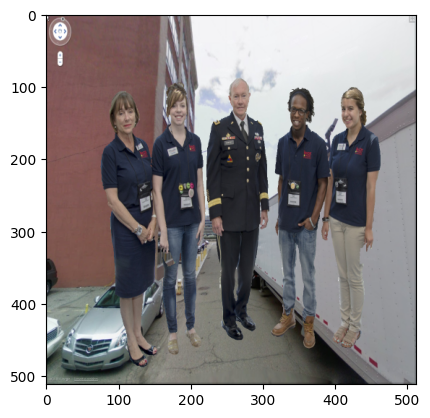

(1, 512, 512)


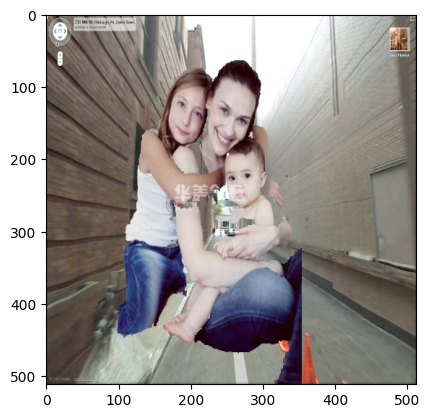

(1, 512, 512)


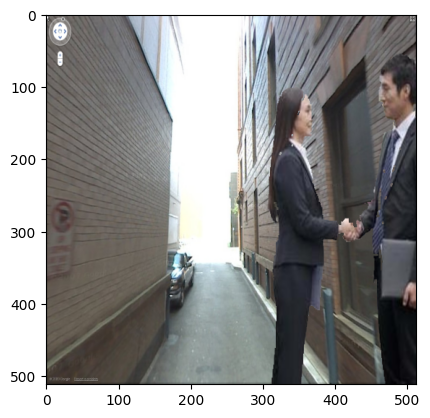

(1, 512, 512)


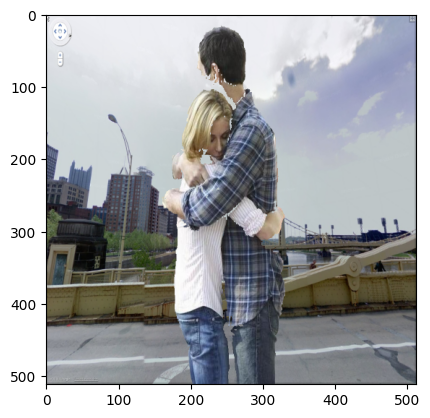

(1, 512, 512)


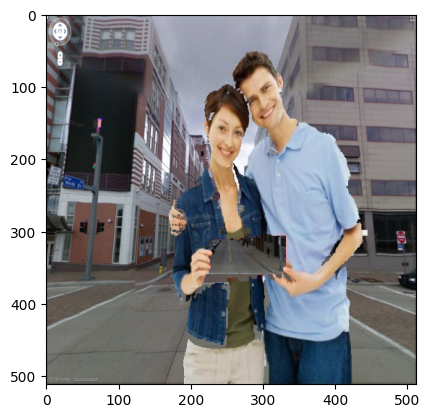

(1, 512, 512)


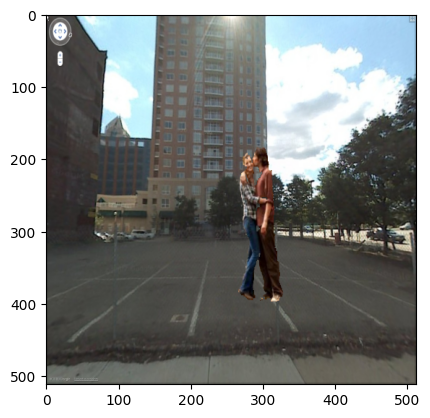

torch.Size([6, 3, 512, 512]) torch.Size([6, 1, 512, 512])


In [8]:
infer_image = None
infer_image_gray = None
file_list = os.listdir(INFER_PATH)
for file_name in file_list:
    image = cv2.cvtColor(cv2.imread(INFER_PATH + file_name), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize = (AIM_RES, AIM_RES)).astype(np.float32) / 255.0
    
    image_gray = image.copy()
    image_gray = np.array([cv2.cvtColor(image_gray, cv2.COLOR_RGB2GRAY)])
    print(image_gray.shape)
    
    plt.imshow(image)
    plt.show()
    
    if infer_image == None:
        infer_image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0)
        infer_image_gray = torch.tensor(image_gray).unsqueeze(0)
    else:
        infer_image = torch.concat([infer_image, torch.tensor(image).permute(2, 0, 1).unsqueeze(0)], dim = 0)
        infer_image_gray = torch.concat([infer_image_gray, torch.tensor(image_gray).unsqueeze(0)], dim = 0)
print(infer_image.shape, infer_image_gray.shape)

In [9]:
output_unet = model_UNet(infer_image_gray.to(device)).cpu().detach()

In [10]:
output_thres = output_unet.numpy()
output_thres[np.where(output_thres >= 0.25)] = np.float32(1.0)
output_thres[np.where(output_thres < 0.25)] = np.float32(0.0)
output_unet = torch.tensor(output_thres)

In [11]:
output_unet_show = output_unet.permute(0, 2, 3, 1).numpy()

In [12]:
only_people = output_unet.repeat(1, 3, 1, 1) * infer_image
only_people = only_people.permute(0, 2, 3, 1).numpy()
only_people_new = list()
for i in range(len(only_people)):
    only_people_new.append(cv2.merge([only_people[i], output_unet_show[i]]))
only_people_new = np.array(only_people_new)
only_people = only_people_new

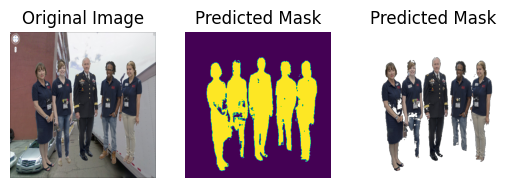

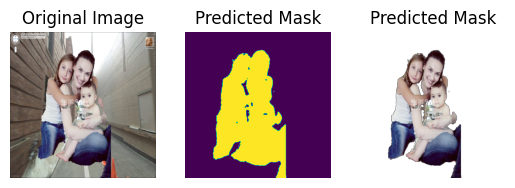

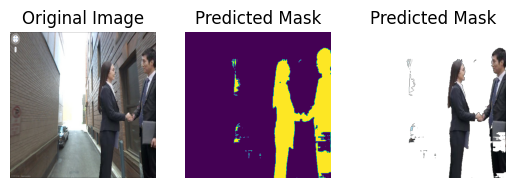

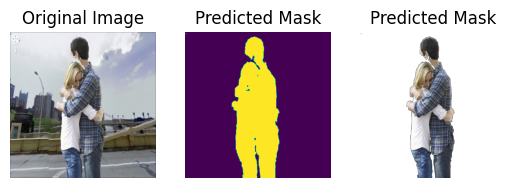

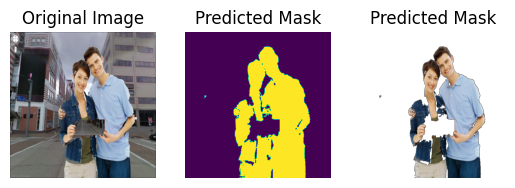

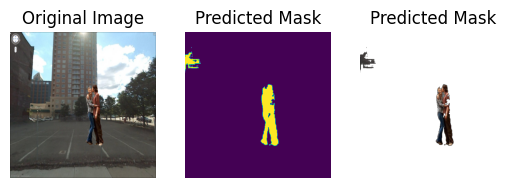

In [13]:
for i in range(len(only_people)):
    plt.subplot(1, 3, 1)
    plt.imshow(infer_image.permute(0, 2, 3, 1)[i])
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(output_unet_show[i])
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(only_people[i])
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

In [14]:
input_fcae = (1 - output_unet) * infer_image

In [15]:
noise_image = np.random.rand(len(input_fcae), 3, AIM_RES, AIM_RES)
noise_idx = np.where(input_fcae.numpy() != 0)
noise_image[noise_idx] = np.float32(0)
input_fcae = torch.tensor((input_fcae.numpy() + noise_image).astype(np.float32))

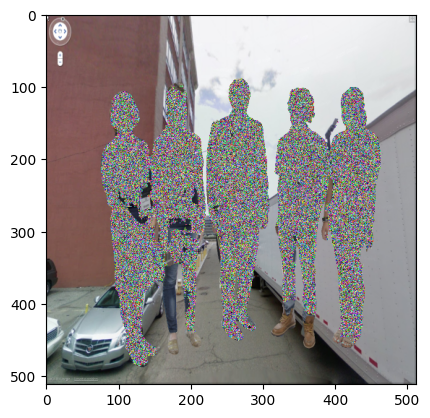

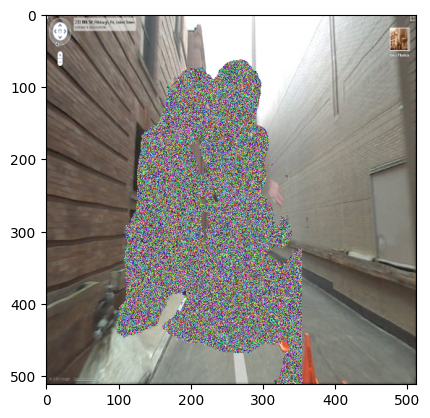

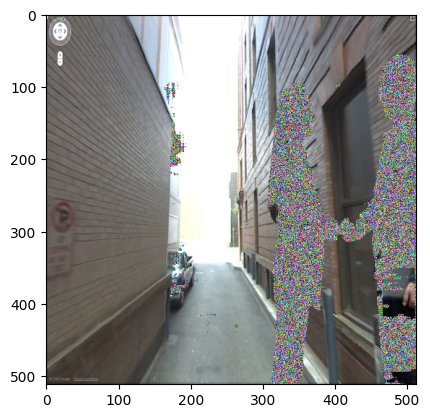

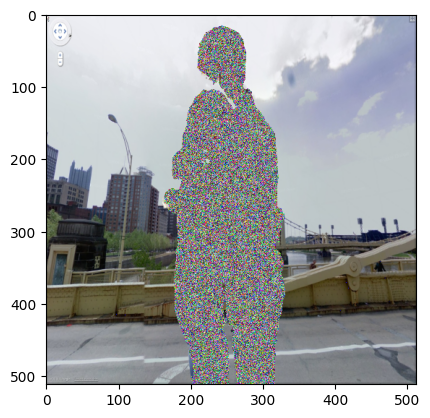

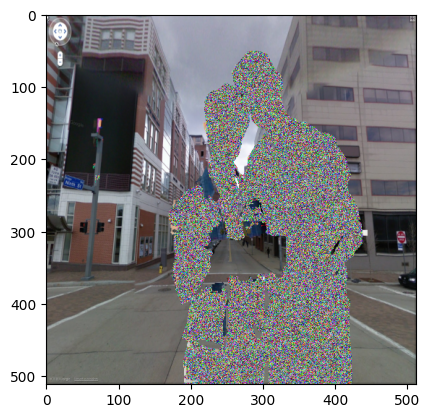

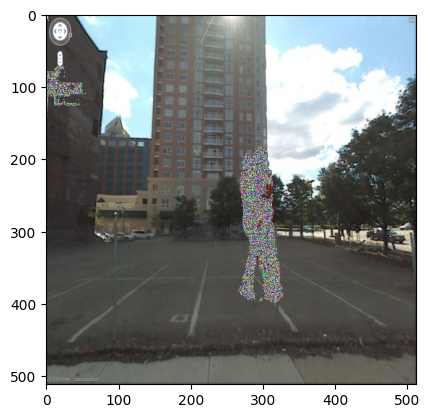

In [16]:
input_fcae_show = input_fcae.permute(0, 2, 3, 1).numpy()
for i in range(len(input_fcae_show)):
    plt.imshow(input_fcae_show[i])
    plt.show()

In [17]:
output_fcae = model_DFCAE(input_fcae.to(device)).cpu().detach()

In [18]:
only_background = output_fcae.permute(0, 2, 3, 1).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


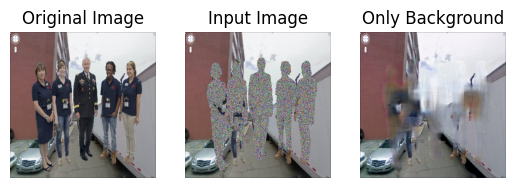

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


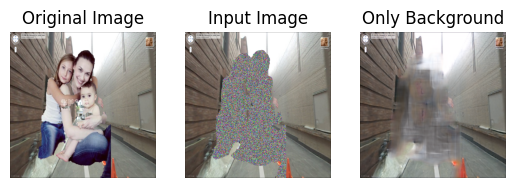

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


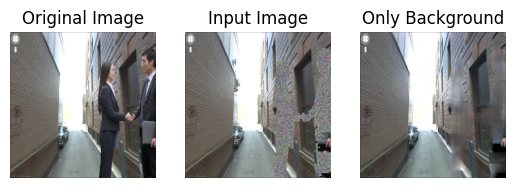

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


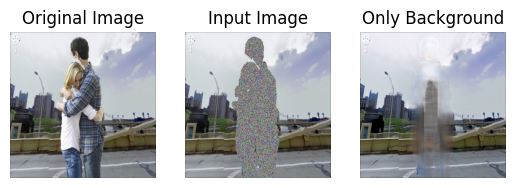

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


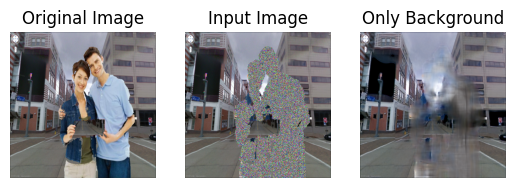

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


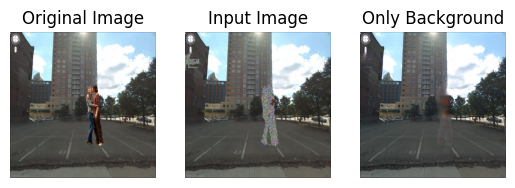

In [19]:
for i in range(len(only_people)):
    plt.subplot(1, 3, 1)
    plt.imshow(infer_image.permute(0, 2, 3, 1)[i])
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(input_fcae_show[i])
    plt.title('Input Image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(only_background[i])
    plt.title('Only Background')
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


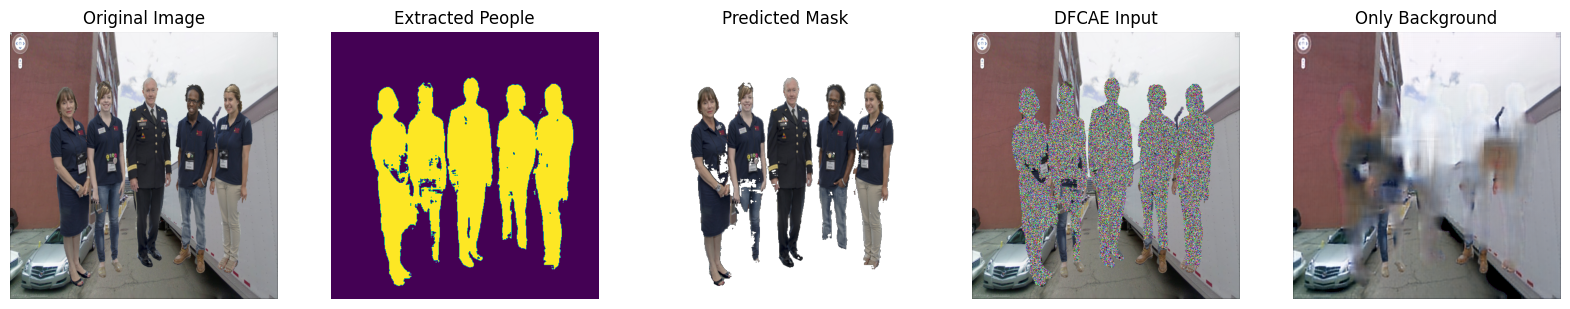

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


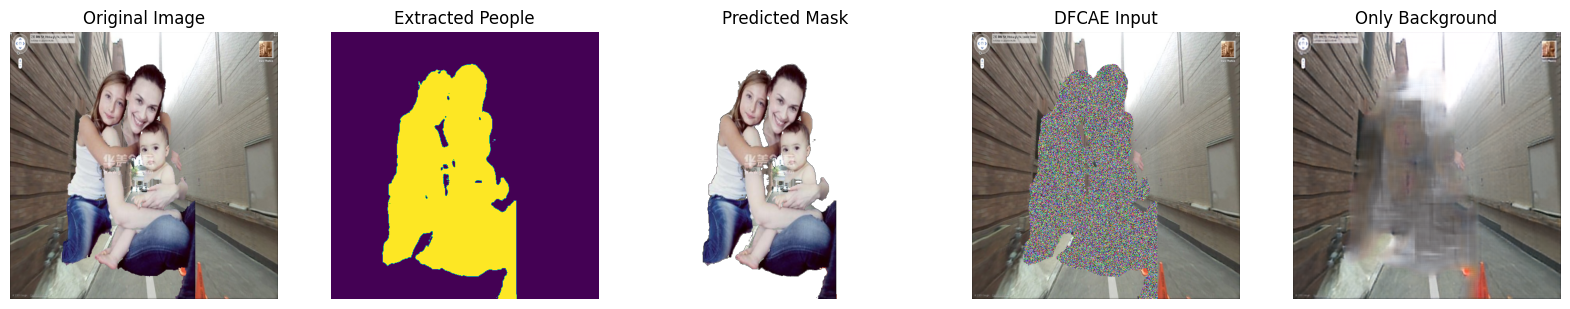

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


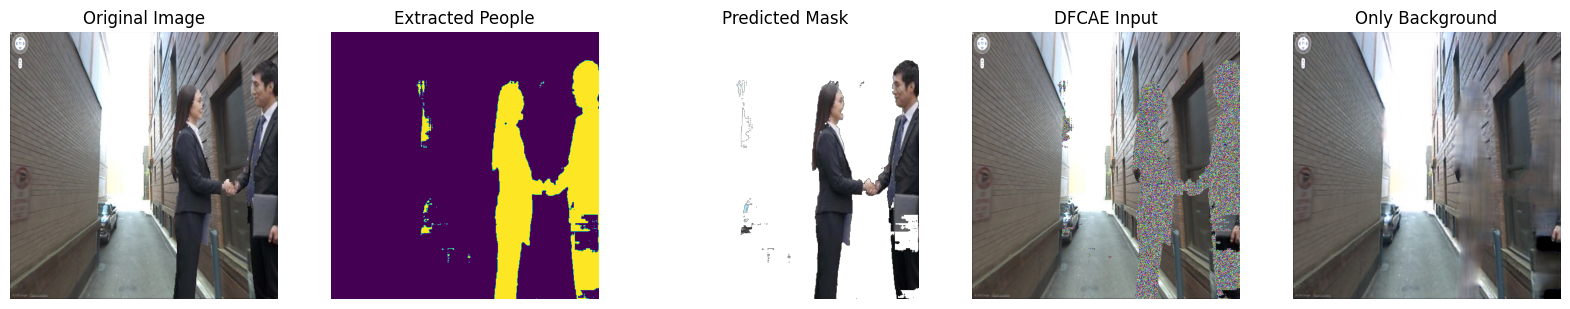

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


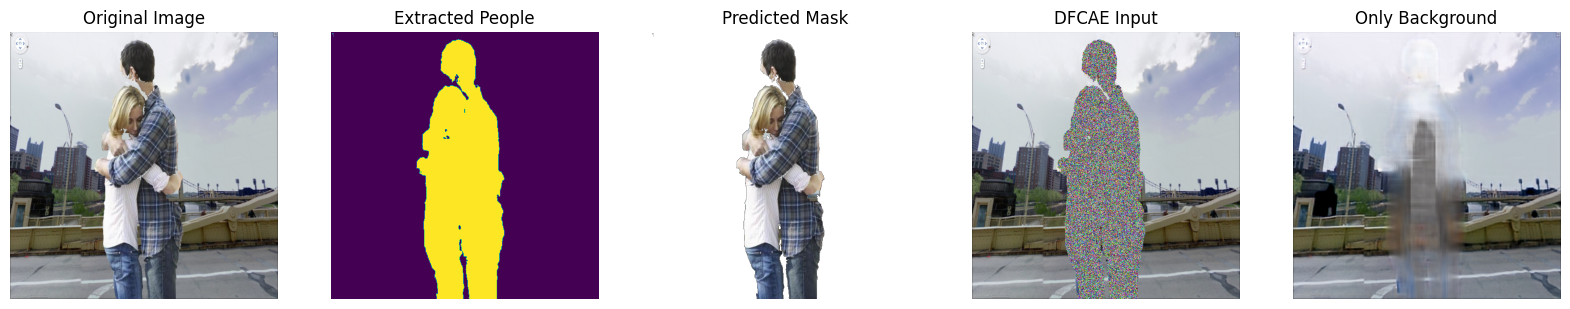

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


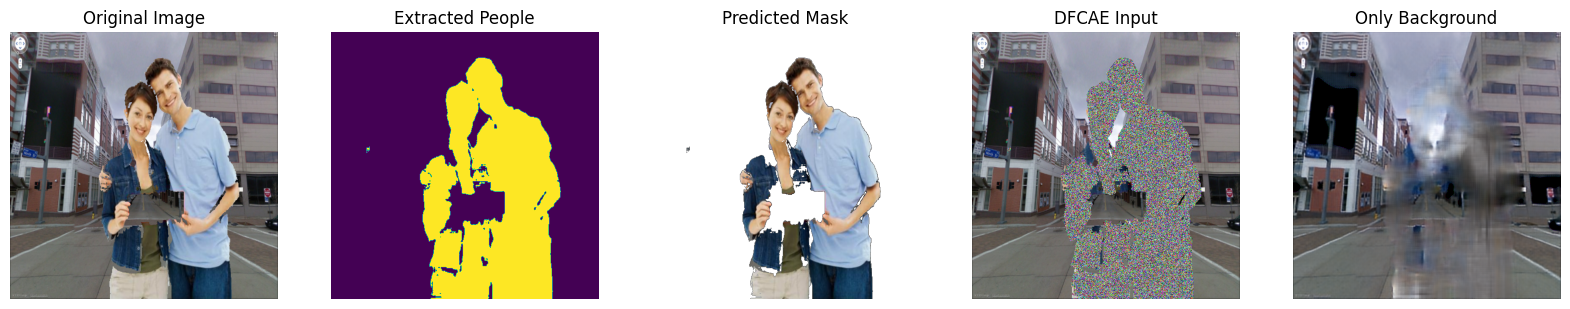

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


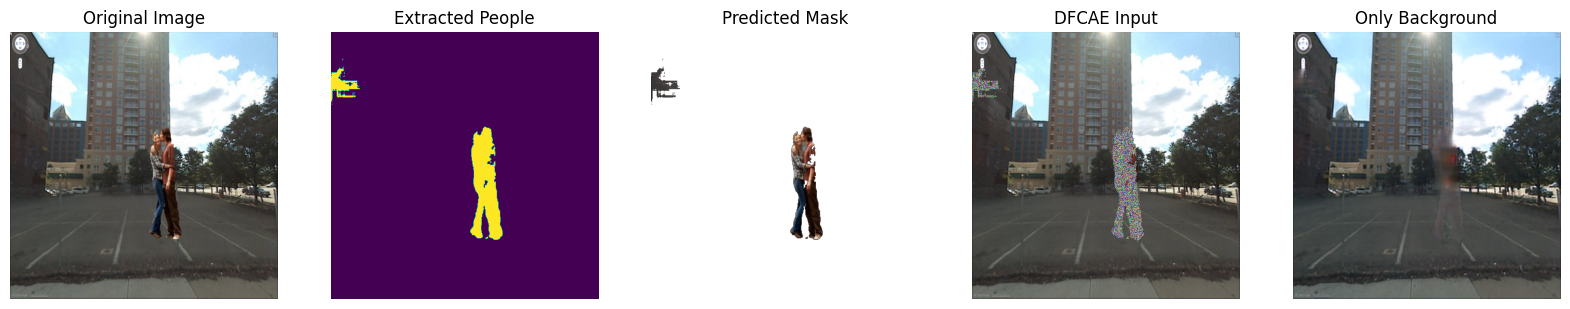

In [20]:
# Final
for i in range(len(only_people)):
    plt.figure(figsize = (20, 4))
    plt.subplot(1, 5, 1)
    plt.imshow(infer_image.permute(0, 2, 3, 1)[i])
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 5, 2)
    plt.imshow(output_unet_show[i])
    plt.title('Extracted People')
    plt.axis('off')
    plt.subplot(1, 5, 3)
    plt.imshow(only_people[i])
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.subplot(1, 5, 4)
    plt.imshow(input_fcae_show[i])
    plt.title('DFCAE Input')
    plt.axis('off')
    plt.subplot(1, 5, 5)
    plt.imshow(only_background[i])
    plt.title('Only Background')
    plt.axis('off')
    plt.show()